In [1]:
import numpy as np
import pandas as pd
import joblib
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import files

In [ ]:
!pip install tensorflow==2.13.0


In [2]:
warnings.filterwarnings('ignore')

In [3]:
uploaded = files.upload()

Saving weather_data.csv to weather_data.csv


In [4]:
data = pd.read_csv('weather_data.csv')
data.head()

,Date,Temperature,Humidity,Wind Speed,Weather Condition
0,2023-01-01,24.967142,45.651709,2.645805,Cloudy
1,2023-01-02,18.617357,97.425578,7.475517,Rainy
2,2023-01-03,26.476885,30.850813,6.283882,Sunny
3,2023-01-04,35.230299,97.891518,13.722689,Cloudy
4,2023-01-05,17.658466,33.021194,5.435908,Cloudy


In [5]:
data.describe()

,Temperature,Humidity,Wind Speed
count,365.000000,365.000000,365.000000
mean,20.099464,65.101860,7.544350
std,9.480511,20.258993,4.466876
min,-12.412673,30.324242,0.095788
25%,13.466708,47.217041,3.475076
50%,20.582087,65.239209,7.865854
75%,26.256673,82.378178,11.507824
max,58.527315,99.980237,14.969012


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               365 non-null    object 
 1   Temperature        365 non-null    float64
 2   Humidity           365 non-null    float64
 3   Wind Speed         365 non-null    float64
 4   Weather Condition  365 non-null    object 
dtypes: float64(3), object(2)
memory usage: 14.4+ KB


In [8]:
#check for null values
data.isnull().sum()

,0
Date,0
Temperature,0
Humidity,0
Wind Speed,0
Weather Condition,0


In [9]:
#check for duplicate rows
data.duplicated().sum()

0

In [10]:
data.shape

(365, 5)

In [11]:
data.columns

Index(['Date', 'Temperature', 'Humidity', 'Wind Speed', 'Weather Condition'], dtype='object')

In [12]:
#seperating categorical and numerical columns
num_cols = data.select_dtypes(include='number').columns
cat_cols = [col for col in data.columns if data[col].dtype=='object' and col != 'Date']
print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)

Numerical Columns:  Index(['Temperature', 'Humidity', 'Wind Speed'], dtype='object')
Categorical Columns:  ['Weather Condition']


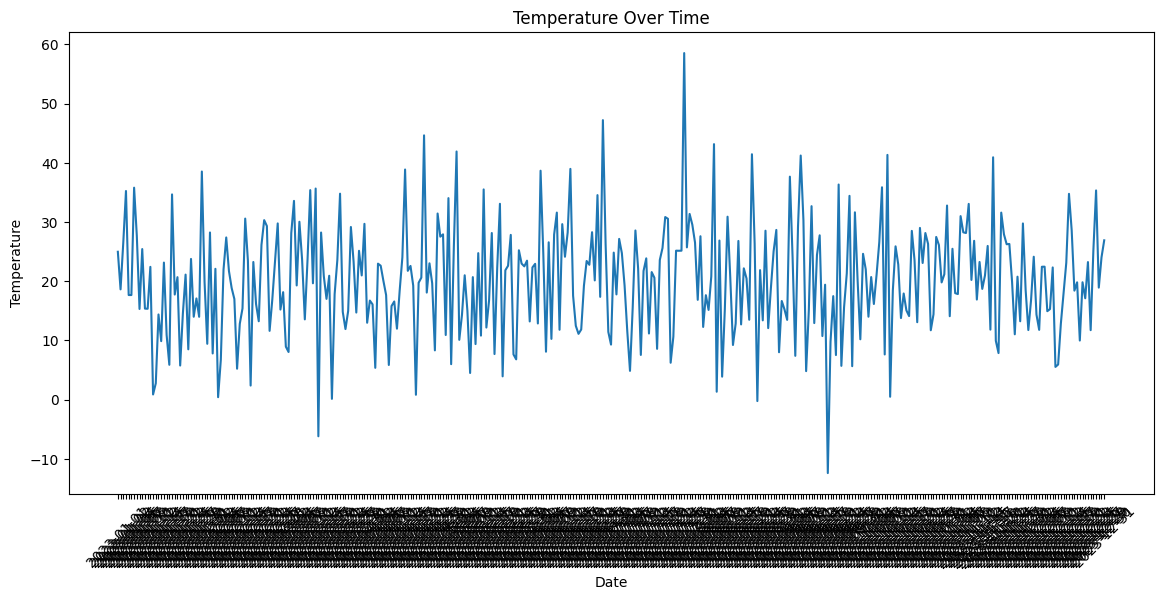

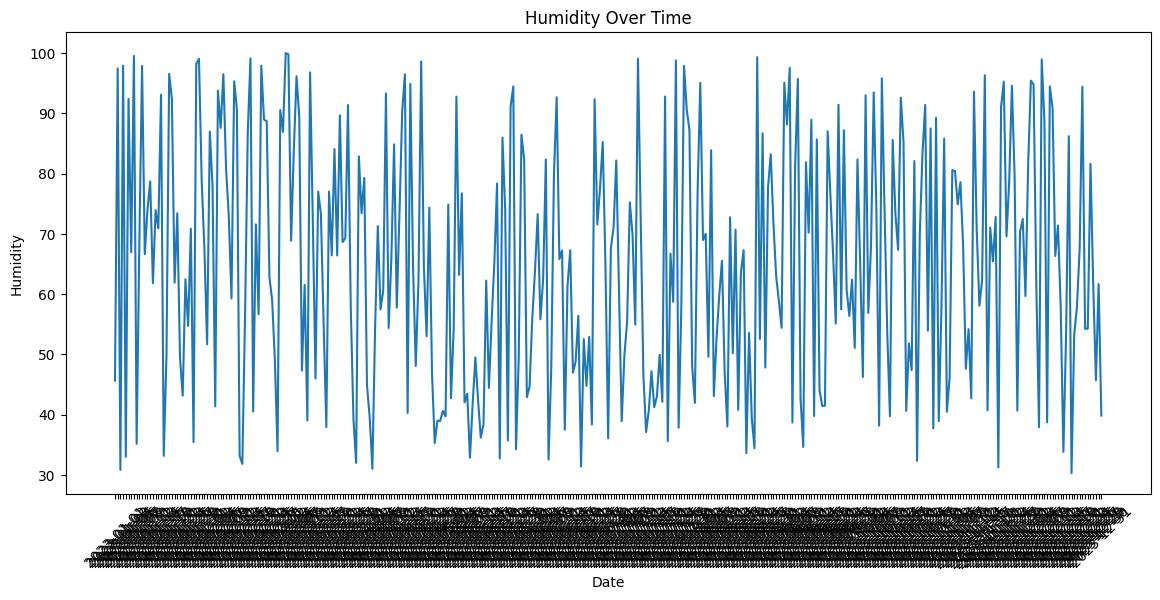

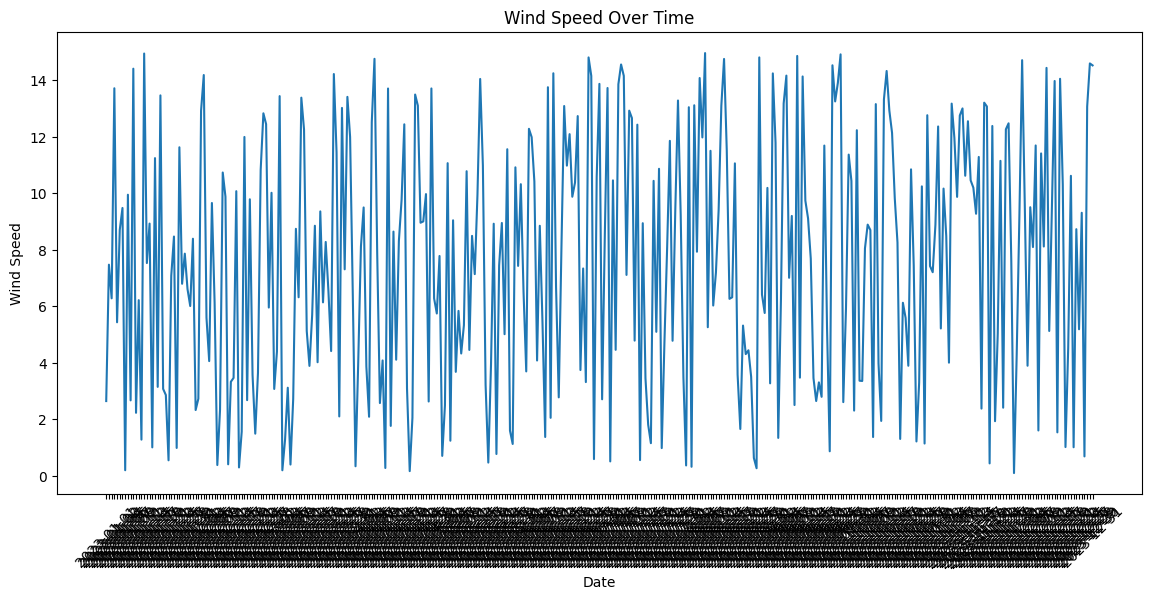

In [13]:
#plot num_cols
for col in num_cols:
  plt.figure(figsize=(14,6))
  sns.lineplot(data=data, x='Date', y=col)
  #plt.xlabel('Date')
  plt.ylabel(col)
  plt.title(f'{col} Over Time')
  plt.xticks(rotation=45)
  plt.show()

In [14]:
#scaling numerical columns
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data[num_cols])
data[num_cols] = scaler.transform(data[num_cols])
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [15]:
data.columns

Index(['Date', 'Temperature', 'Humidity', 'Wind Speed', 'Weather Condition'], dtype='object')

In [16]:
#rearrange column order
new_order = ['Humidity', 'Wind Speed', 'Temperature']
data = data[new_order]
data.head()

,Humidity,Wind Speed,Temperature
0,-0.559910,-0.657100,0.053843
1,0.926649,-0.007649,-0.125175
2,-0.984881,-0.167888,0.096407
3,0.940028,0.832407,0.343191
4,-0.922564,-0.281915,-0.152209


In [17]:
#creating time steps
def createTimeSteps(df,time_steps):
  X = []
  y = []
  for i in range(len(df)-time_steps):
    X.append(df.iloc[i:i+time_steps].values)
    y.append(df.iloc[i+time_steps][-1])
  return np.array(X), np.array(y)

In [18]:
X, y = createTimeSteps(data,5)

In [19]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [20]:
X_train.shape

(230, 5, 3)

In [21]:
y_train.shape

(230,)

In [22]:
#build model
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(LSTM(units=128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [23]:
#compile model
optimizer = Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=6, min_lr=1e-6, verbose=1)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [24]:
#train model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/50
4/4 [==============================] - 5s 186ms/step - loss: 0.0819 - mae: 0.2236 - val_loss: 0.1019 - val_mae: 0.2569 - lr: 1.0000e-04
Epoch 2/50
4/4 [==============================] - 0s 41ms/step - loss: 0.0810 - mae: 0.2221 - val_loss: 0.1008 - val_mae: 0.2555 - lr: 1.0000e-04
Epoch 3/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0801 - mae: 0.2211 - val_loss: 0.0998 - val_mae: 0.2540 - lr: 1.0000e-04
Epoch 4/50
4/4 [==============================] - 0s 45ms/step - loss: 0.0794 - mae: 0.2199 - val_loss: 0.0987 - val_mae: 0.2525 - lr: 1.0000e-04
Epoch 5/50
4/4 [==============================] - 0s 46ms/step - loss: 0.0787 - mae: 0.2193 - val_loss: 0.0978 - val_mae: 0.2509 - lr: 1.0000e-04
Epoch 6/50
4/4 [==============================] - 0s 36ms/step - loss: 0.0779 - mae: 0.2184 - val_loss: 0.0969 - val_mae: 0.2495 - lr: 1.0000e-04
Epoch 7/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0771 - mae: 0.2174 - val_loss: 0.0960 - val_mae: 0

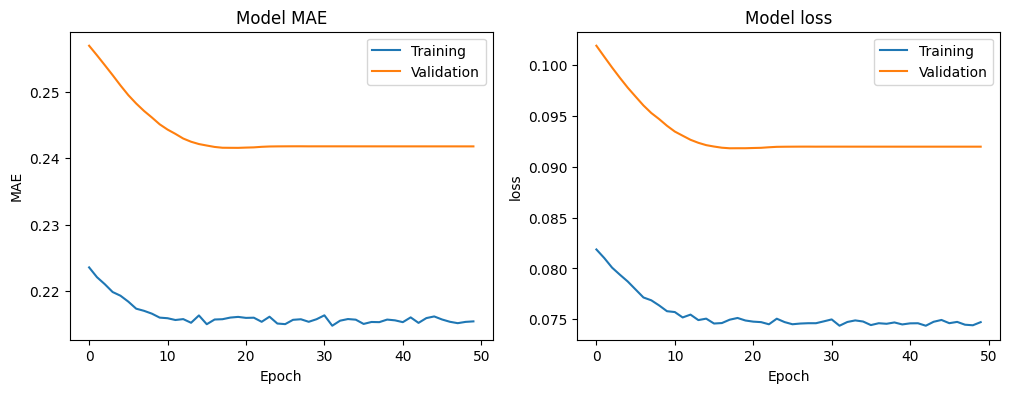

In [25]:
#model performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='training')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [26]:
#making predictions
y_pred=model.predict(X_test)

3/3 [==============================] - 1s 10ms/step


In [27]:
y_test.shape

(72,)

In [28]:
y_pred.shape

(72, 1)

In [29]:
#evaluate predictions: MSE
y_pred = y_pred.reshape(-1, 1)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")

Test Mean Squared Error (MSE): 0.0442


In [30]:
#saving model
model.save('weather_model.h5')

In [31]:
!pip freeze > requirements.txt

In [32]:
#download the files
files.download('scaler.pkl')
files.download('weather_model.h5')
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>